Simplest form of selecting features: remove features with very low variance.
Also remove the features with high correlation.

In [22]:
import pandas as pd
from sklearn.datasets import fetch_california_housing
import numpy as np
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectPercentile
from sklearn import linear_model
from sklearn import metrics
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel


In [ ]:
# fetch a regression dataset
data = fetch_california_housing()
X = data["data"]
col_names = data["feature_names"]
y = data["target"]

# create a pandas dataframe
df = pd.DataFrame(X, columns=col_names)

# introduce a highly correlated column
df.loc[:, "MedInc_Sqrt"] = df.MedInc.apply(np.sqrt)

df.corr()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedInc_Sqrt
MedInc,1.000000,-0.119034,0.326895,-0.062040,0.004834,0.018766,-0.079809,-0.015176,0.984329
HouseAge,-0.119034,1.000000,-0.153277,-0.077747,-0.296244,0.013191,0.011173,-0.108197,-0.132797
AveRooms,0.326895,-0.153277,1.000000,0.847621,-0.072213,-0.004852,0.106389,-0.027540,0.326688
AveBedrms,-0.062040,-0.077747,0.847621,1.000000,-0.066197,-0.006181,0.069721,0.013344,-0.066910
Population,0.004834,-0.296244,-0.072213,-0.066197,1.000000,0.069863,-0.108785,0.099773,0.018415
AveOccup,0.018766,0.013191,-0.004852,-0.006181,0.069863,1.000000,0.002366,0.002476,0.015266
Latitude,-0.079809,0.011173,0.106389,0.069721,-0.108785,0.002366,1.000000,-0.924664,-0.084303
Longitude,-0.015176,-0.108197,-0.027540,0.013344,0.099773,0.002476,-0.924664,1.000000,-0.015569
MedInc_Sqrt,0.984329,-0.132797,0.326688,-0.066910,0.018415,0.015266,-0.084303,-0.015569,1.000000


#### Univariate feature selection
Some popular methods: Mutual information, ANOVA F-test and chi2
1. SelectKBest: keep the top-k scoring features
2. SelectPercentile: It keeps the top features which are in a percentage
specified by the user

In [4]:
class UnivariateFeatureSelction:
    def __init__(self, n_features, problem_type, scoring):
        """

        Args:
            n_features (_type_): SelectPercentile if float else SelectKBest 
            problem_type (_type_): classification or regression
            scoring (_type_): scoring function, string
        """
        if problem_type == "classification":
            valid_scoring = {
                "f_classif": f_classif,
                "chi2": chi2,
                "mutual_info_classif": mutual_info_classif
            }
        else:
            valid_scoring = {
                "f_regression": f_regression,
                "mutual_info_regression": mutual_info_regression
            }
        if scoring not in valid_scoring:
            raise Exception("Invalid scoring function")
        
        if isinstance(n_features, int):
            self.selection = SelectKBest(
                valid_scoring[scoring], k=n_features)
        elif isinstance(n_features, float):
            self.selection = SelectPercentile(
                valid_scoring[scoring], percentile=int(n_features * 100))

        else:
            raise Exception("Invalid type of feature")
        
    def fit(self, X, y): return self.selection.fit(X, y)
    
    def transform(self, X): return self.selection.transform(X)
    
    def fit_transform(self, X, y): return self.selection.fit_transform(X, y)

In [5]:
ufs = UnivariateFeatureSelction(
n_features=0.1,
problem_type="regression",
scoring="f_regression"
)

ufs.fit(X, y)

X_transformed = ufs.transform(X)

X_transformed

array([[8.3252],
       [8.3014],
       [7.2574],
       ...,
       [1.7   ],
       [1.8672],
       [2.3886]])

### greedy feature selection
1. choose a model
2. select a loss/scoring function
3. iteratively evaluate each feature and add it to the list of "good" feature if it improves loss/score

In [23]:

class GreedyFeatureSelection:
    def evaluate_score(self, X, y):
        """This function evaluates model on data and returns the Area Under ROC Curve (AUC)
        Args:
            X: training data
            y: targets
        Returns: 
            float: area under the roc curve
        """
        model = linear_model.LogisticRegression()
        model.fit(X, y)
        predictions = model.predict_proba(X)[:, 1]
        auc = metrics.roc_auc_score(y, predictions)
        return auc
        
    def _feature_selection(self, X, y):
        """This function does the actual greedy selection
        Args:
            X: data, numpy array
            y: targets, numpy array
        Returns: 
            tuple: (best scores, best features)
        """
        good_features = []
        best_scores = []
        
        num_features = X.shape[1]
        
        while True:
            this_feature = None
            best_score = 0
            
            for feature in range(num_features):
                # if feature is already in good features, skip this
                if feature in good_features:
                    continue
                    
                selected_features = good_features + [feature]
                
                # remove all other features from data
                xtrain = X[:, selected_features]
                
                # calculate the score, in this case, AUC
                score = self.evaluate_score(xtrain, y)
                if score > best_score:
                    this_feature = feature
                    best_score = score
            
            # Moved outside the feature loop
            if this_feature is not None:
                good_features.append(this_feature)
                best_scores.append(best_score)
                
                # if we did not improve during the last round, exit the loop
                if len(best_scores) > 2:
                    if best_scores[-1] < best_scores[-2]:
                        break
            else:
                break  # No improvement found in this iteration
                
        return best_scores[:-1], good_features[:-1]
    
    def __call__(self, X, y):
        """Call function will call the class on a set of arguments
        Args:
            X: input features
            y: target values
        Returns:
            tuple: (transformed features, scores)
        """
        scores, features = self._feature_selection(X, y)
        return X[:, features], scores
    

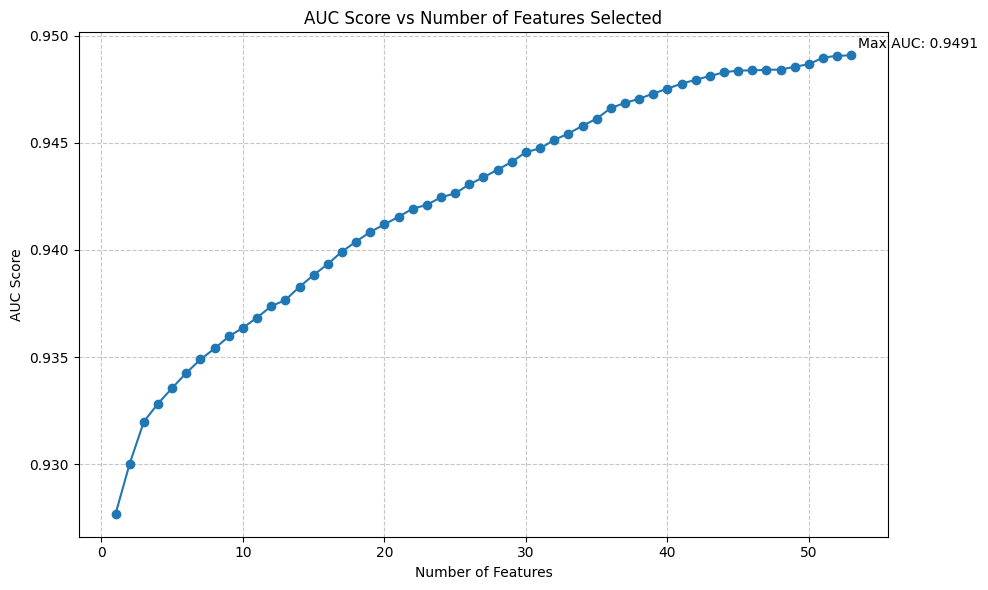

Original number of features: 100
Number of selected features: 53
Maximum AUC achieved: 0.9491 with 53 features


In [24]:
if __name__ == "__main__":
    
    # Set random state for reproducibility
    random_state = 42
    
    # generate binary classification data
    X, y = make_classification(
        n_samples=1000, 
        n_features=100,
        random_state=random_state
    )
    
    try:
        # Initialize and run feature selection
        selector = GreedyFeatureSelection()
        X_transformed, scores = selector(X, y)
        
        # Create the plot
        plt.figure(figsize=(10, 6))
        iterations = range(1, len(scores) + 1)
        plt.plot(iterations, scores, marker='o')
        
        # Customize the plot
        plt.title('AUC Score vs Number of Features Selected')
        plt.xlabel('Number of Features')
        plt.ylabel('AUC Score')
        plt.grid(True, linestyle='--', alpha=0.7)
        
        # Add annotations for max score
        max_score_idx = np.argmax(scores)
        max_score = scores[max_score_idx]
        plt.annotate(f'Max AUC: {max_score:.4f}', 
                    xy=(max_score_idx + 1, max_score),
                    xytext=(5, 5), textcoords='offset points')
        
        # Show the plot
        plt.tight_layout()
        plt.show()
        
        # Print summary statistics
        print(f"Original number of features: {X.shape[1]}")
        print(f"Number of selected features: {X_transformed.shape[1]}")
        print(f"Maximum AUC achieved: {max_score:.4f} with {max_score_idx + 1} features")
        
    except Exception as e:
        print(f"An error occurred: {str(e)}")

Recursive feature elimination

In [25]:
data = fetch_california_housing()
X = data["data"]
col_names = data["feature_names"]
y = data["target"]

# initialize the model
model = LinearRegression()
# initialize RFE
rfe = RFE(
estimator=model,
n_features_to_select=3
)

# fit RFE
rfe.fit(X, y)

# get the transformed data with selected columns
X_transformed = rfe.transform(X)

# Print results
print("Selected features:")
for i, selected in enumerate(rfe.support_):
    rank = rfe.ranking_[i]
    if selected:
        print(f"{col_names[i]}: Selected (Rank: {rank})")
    else:
        print(f"{col_names[i]}: Not selected (Rank: {rank})")

print("\nShape of transformed data:", X_transformed.shape)

Selected features:
MedInc: Selected (Rank: 1)
HouseAge: Not selected (Rank: 4)
AveRooms: Not selected (Rank: 3)
AveBedrms: Not selected (Rank: 2)
Population: Not selected (Rank: 6)
AveOccup: Not selected (Rank: 5)
Latitude: Selected (Rank: 1)
Longitude: Selected (Rank: 1)

Shape of transformed data: (20640, 3)


Can also set a threshold, and if the coefficient is above that threshold, you can keep the feature else eliminate it.

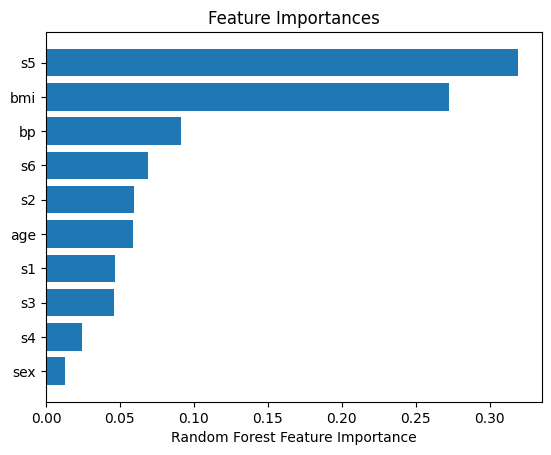

In [26]:
data = load_diabetes()
X = data["data"]
col_names = data["feature_names"]
y = data["target"]

# initialize the model
model = RandomForestRegressor()
# fit the model
model.fit(X, y)

importances = model.feature_importances_
idxs = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(idxs)), importances[idxs], align='center')
plt.yticks(range(len(idxs)), [col_names[i] for i in idxs])
plt.xlabel('Random Forest Feature Importance')
plt.show()

Scikit-learn also offers SelectFromModel class that helps you choose features directly from a given model.

In [27]:
data = load_diabetes()
X = data["data"]
col_names = data["feature_names"]
y = data["target"]
# initialize the model
model = RandomForestRegressor()

# select from the model
sfm = SelectFromModel(estimator=model)
X_transformed = sfm.fit_transform(X, y)
# see which features were selected
support = sfm.get_support()
# get feature names
print([
x for x, y in zip(col_names, support) if y == True
])


['bmi', 'bp', 's5']


#### Can also use models that have L1 regularization